In [1]:
from networks.attention_agent import CausalAttentionAgent
import torch
from utils.trading_gym_env import TradingEnv
from utils.synthetic_data_service import SyntheticOHLCVGenerator
import pandas as pd
import matplotlib.pyplot as plt
from diffevo import DDIMScheduler, BayesianGenerator
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from utils.fitess_funcs import batched_fitness_function
from api_wrappers.kraken_wrapper import KrakenWrapper
kw = KrakenWrapper()
dfs = kw.load_hist_files()

c:\Users\nick5\miniconda3\envs\tree-env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [19]:
import numpy as np
import random

print(len(dfs))

def add_features(df):
    df.columns = [col.lower() for col in df.columns]
    print(df.head())
    # Ensure columns are numeric
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df['high'] = pd.to_numeric(df['high'], errors='coerce')
    df['low'] = pd.to_numeric(df['low'], errors='coerce')
    df['vol'] = pd.to_numeric(df['vol'], errors='coerce')

    # Add log returns
    df['log_return'] = np.log(df['close']).diff()

    # Add moving averages
    df['ma_10'] = df['close'].rolling(window=10).mean()
    df['ma_50'] = df['close'].rolling(window=50).mean()

    # Add Fibonacci levels
    fib_ratios = [0.0, 0.236, 0.382, 0.5, 0.618, 1.0]
    for ratio in fib_ratios:
        df[f'fib_{int(ratio * 1000)}'] = np.nan
    for i in range(20, len(df)):
        high = df['high'].iloc[i-20:i].max()
        low = df['low'].iloc[i-20:i].min()
        for ratio in fib_ratios:
            level = high - (high - low) * ratio
            df.at[i, f'fib_{int(ratio * 1000)}'] = level

    # Drop NaN rows
    df = df.dropna().reset_index(drop=True)
    return df
train_size = int(len(list(dfs.items())[0][1]) * 0.6)
# Add features to all dataframes
dfs = {asset: add_features(df) for asset, df in dfs.items()}
def split_train_test(df, train_ratio=0.8):
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
    return train_df, test_df

# Split all dataframes into train/test sets
train_test_data = {asset: split_train_test(df) for asset, df in dfs.items()}
def prepare_data(df, seq_len):
    states = []
    price_changes = []

    for i in range(len(df) - seq_len):
        state = df.iloc[i:i+seq_len][['log_return', 'ma_10', 'ma_50']].values
        price_change = df.iloc[i+seq_len]['log_return']
        states.append(state)
        price_changes.append(price_change)

    states = torch.tensor(states, dtype=torch.float32)  # Shape: (num_samples, seq_len, num_features)
    price_changes = torch.tensor(price_changes, dtype=torch.float32)  # Shape: (num_samples,)
    return states, price_changes

# Prepare data for all assets
seq_len = 144
train_data = {asset: prepare_data(train, seq_len) for asset, (train, _) in train_test_data.items()}
test_data = {asset: prepare_data(test, seq_len) for asset, (_, test) in train_test_data.items()}

22
         date      open      high       low     close      vwap           vol  \
0  1707091200  0.493367  0.505404  0.488000  0.494246  0.494287  1.039293e+06   
1  1707177600  0.494246  0.504000  0.489976  0.498563  0.498556  6.057023e+05   
2  1707264000  0.499144  0.502357  0.466064  0.502000  0.477648  5.491872e+06   
3  1707350400  0.502137  0.535569  0.502135  0.529962  0.517441  7.744015e+06   
4  1707436800  0.530756  0.548144  0.528513  0.540046  0.538431  2.068370e+06   

   log_return     ma_10     ma_50     fib_0   fib_236   fib_382   fib_500  \
0    0.000520  0.503416  0.545709  0.548091  0.524470  0.509856  0.498046   
1    0.008697  0.504675  0.543625  0.539343  0.517786  0.504450  0.493672   
2    0.006870  0.505907  0.542157  0.537347  0.516261  0.503216  0.492673   
3    0.054205  0.506391  0.540956  0.537347  0.516261  0.503216  0.492673   
4    0.018849  0.509096  0.539047  0.537347  0.516261  0.503216  0.492673   

    fib_618  fib_1000  
0  0.486235     0.448  

In [ ]:
import torch.nn.functional as F

def run(x_array, population, agent):
    rewards = []
    # Example of a random walk in the environment
    for xp in population:
        vector_to_parameters(torch.tensor(xp, dtype=torch.float32), agent.parameters())
        rewards.append(batched_fitness_function(agent, x_array))
    return rewards

# Define hyperparameters
POP_SIZE = 100
SCALING = 0.1

# Instantiate the model
STATE_DIM = train_data[list(train_data.keys())[0]][0].shape[-1]  # Number of features
ACTION_DIM = 2  # Buy, Sell
EP_LEN = 55
agent_model = CausalAttentionAgent(state_dim=STATE_DIM, embed_dim=64, action_dim=ACTION_DIM, seq_len=seq_len)

# Initialize population
dim = parameters_to_vector(agent_model.parameters()).shape[0]
population = torch.randn(POP_SIZE, dim) * SCALING

# Fitness function
def fitness_function(population, agent, train_data, num_assets=10):
    """
    Evaluate the fitness of the population on a randomly selected batch of assets.

    Args:
        population: The population of agent parameters.
        agent: The trading agent model.
        train_data: Dictionary of training data for all assets.
        num_assets: Number of assets to randomly select for evaluation.

    Returns:
        List of rewards for each member of the population.
    """
    # Randomly select a batch of assets
    selected_assets = random.sample(list(train_data.keys()), num_assets)
    #print(f"Selected assets for this generation: {selected_assets}")

    # Combine states and price changes for the selected assets
    batch_states = torch.stack([train_data[asset][0] for asset in selected_assets], dim=0)  # Shape: (batch, ep_len, seq_len, features)
    batch_price_changes = torch.stack([train_data[asset][1] for asset in selected_assets], dim=0)  # Shape: (batch, ep_len)

    population_rewards = torch.zeros(len(population), len(selected_assets))  # Shape: (population_size, num_assets)

    for i, params in enumerate(population):
        # Update the agent's parameters
        vector_to_parameters(params, agent.parameters())

        # Evaluate the agent on the batch
        rewards = batched_fitness_function(agent, batch_states, batch_price_changes)  # Shape: (batch, 1)
        population_rewards[i] = rewards.squeeze()  # Store rewards for this parameter set

    # Normalize rewards per asset using softmax
    normalized_rewards = F.softmax(population_rewards, dim=0)  # Normalize across the population for each asset
    '''print("Population rewards (before normalization):", population_rewards)
    print("Normalized rewards (softmax across assets):", normalized_rewards)
    print("Sum of normalized rewards per parameter set:", normalized_rewards.sum(dim=1)) '''
    # Sum normalized rewards across all assets for each parameter set
    final_rewards = normalized_rewards.sum(dim=1)  # Shape: (population_size,)
    print(final_rewards)
    return final_rewards

# Train with diffusion evolution
scheduler = DDIMScheduler(num_step=42)
for t, alpha in scheduler:  # Number of training steps
    rewards = fitness_function(population, agent_model, train_data)
    print(f"Step {t}, Best Reward: {max(rewards)}")
    generator = BayesianGenerator(population, rewards, alpha)
    population = generator(noise=0)
    best_para = population[-1]
    torch.save(best_para, 'best_attention_agent.pth')

KeyboardInterrupt: 

C:\Users\nick5\AppData\Local\Temp\ipykernel_26956\2021625538.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_params = torch.load(saved_population_path)


torch.Size([50114])
torch.Size([50114])
Selected assets for evaluation: ['DAIUSDT.txt', 'SHIBUSDT.txt', 'USDCUSDT.txt', 'LINKUSDT.txt', 'XBTUSDT.txt', 'ADAUSDT.txt', 'BCHUSDT.txt', 'MANAUSDT.txt', 'ETHUSDT.txt', 'LTCUSDT.txt']
torch.Size([10, 37])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 

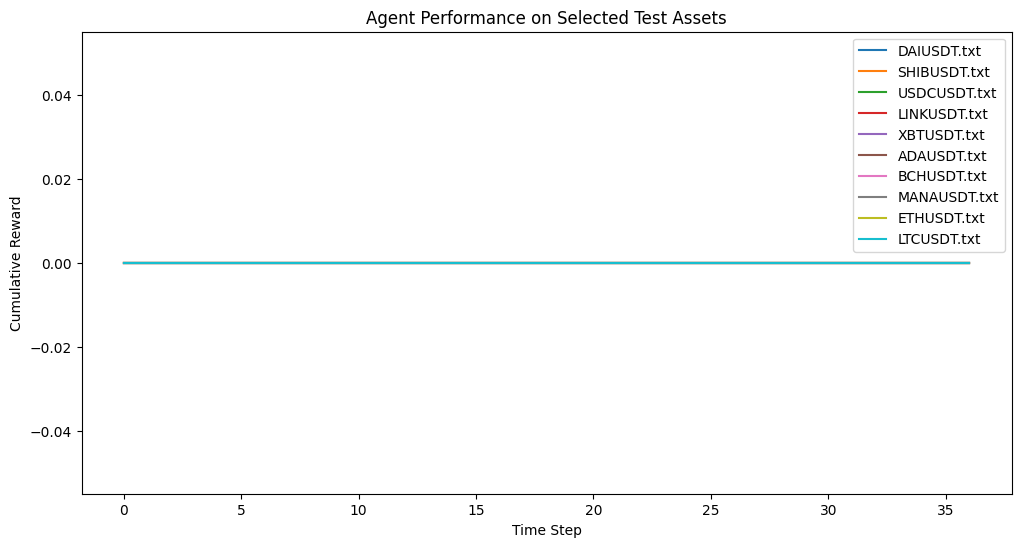

Test rewards for the best agent: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.

In [33]:
import matplotlib.pyplot as plt
# Load the saved population
saved_population_path = 'best_attention_agent.pth'
best_params = torch.load(saved_population_path)
current_params = parameters_to_vector(agent_model.parameters())
print(current_params.shape)
print(best_params.shape)
vector_to_parameters(best_params, agent_model.parameters())
# Evaluate the best parameters on the test set and plot performance
def evaluate_population_on_test(agent, test_data, num_assets=10):
    """
    Evaluate the saved population on the test set and plot performance.

    Args:
        agent: The trading agent model.
        test_data: Dictionary of test data for all assets.
        num_assets: Number of assets to randomly select for evaluation.

    Returns:
        List of rewards for the best parameters on the test set.
    """
    # Randomly select a batch of assets
    selected_assets = random.sample(list(test_data.keys()), num_assets)
    print(f"Selected assets for evaluation: {selected_assets}")

    # Combine states and price changes for the selected assets
    batch_states = torch.stack([test_data[asset][0] for asset in selected_assets], dim=0)  # Shape: (batch, ep_len, seq_len, features)
    batch_price_changes = torch.stack([test_data[asset][1] for asset in selected_assets], dim=0)  # Shape: (batch, ep_len)

    # Load the best parameters into the agent
    vector_to_parameters(best_params, agent.parameters())

    # Evaluate the agent on the test set
    batch, ep_len = batch_price_changes.shape
    print(batch_price_changes.shape)
    rewards = torch.zeros(batch, ep_len)  # Initialize rewards for each asset over time

    for t in range(ep_len - 1):
        # Get the current state for all assets at time t
        current_states = batch_states[:, t, :, :]  # Shape: (batch, seq_len, features)

        # Get actions for all assets in the batch
        actions = agent(current_states)  # Shape: (batch, 2) -> 2 actions: Buy, Sell
        actions = torch.argmax(actions, dim=-1)  # Convert to discrete actions (0=Sell, 1=Buy)

        # Convert actions to -1 (Sell) and 1 (Buy)
        #actions = actions.float() * 2 - 1  # Map (0, 1) -> (-1, 1)
        print(actions)
        # Calculate rewards as the product of actions and percentage changes
        rewards[:, t + 1] = rewards[:, t] + (actions * batch_price_changes[:, t + 1])

    # Plot cumulative rewards for each asset
    plt.figure(figsize=(12, 6))
    for i, asset in enumerate(selected_assets):
        plt.plot(rewards[i].numpy(), label=asset)
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Reward')
    plt.title('Agent Performance on Selected Test Assets')
    plt.legend()
    plt.show()

    return rewards

# Evaluate the best agent on the test set and plot performance
test_rewards = evaluate_population_on_test(agent_model, test_data, num_assets=10)
print("Test rewards for the best agent:", test_rewards)